# Creating and training your own dataset from Google Images

*by: Giedrius Blazys. Inspired by Francisco Ingham, Jeremy Howard and [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

Here is a great resource to automate the downloading of google or bing images: [ai_utilities](https://github.com/prairie-guy/ai_utilities)

In [1]:
from fastai import *
from fastai.vision import *

We start with a dataset of Coca Cola, Pepsi Cola, Nuka Cola and other images, which where downloaded using Google image search.

In [2]:
classes = ['coca_cola', 'nuka_cola', 'other', 'pepsi_cola']

In [3]:
path = Path('data/cola')

Then we can remove any images that can't be opened:

In [11]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

coca_cola


pepsi_cola


nuka_cola


other


In [8]:
bs = 64
size = 128
size_big = 299

In [13]:
get_y_fn = lambda o: o.parent.name

In [14]:
np.random.seed(41)

src = (ImageFileList.from_folder(path)
       .label_from_func(get_y_fn)
       .random_split_by_pct(0.2))

In [15]:
data = (src.datasets()
        .transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

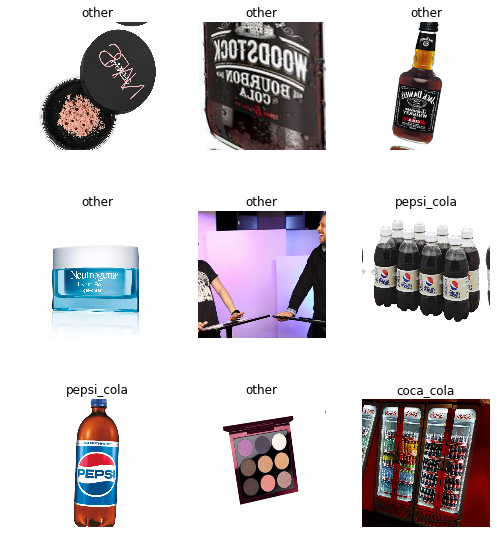

In [17]:
data.show_batch(rows=3, figsize=(7,8))

In [18]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['coca_cola', 'nuka_cola', 'other', 'pepsi_cola'], 4, 1372, 342)

## Train model

In [19]:
learn = create_cnn(data, models.resnet50, metrics=error_rate) 

In [20]:
learn.freeze()

In [21]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


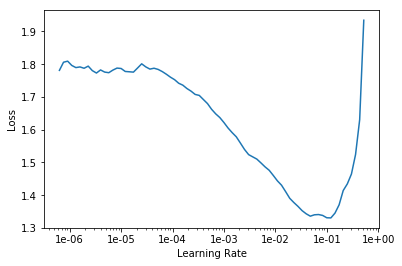

In [22]:
learn.recorder.plot()

In [23]:
lr = 0.001

In [24]:
learn.fit_one_cycle(6, slice(lr))

Total time: 01:05
epoch  train_loss  valid_loss  error_rate
1      1.468551    1.078428    0.400585    (00:11)
2      1.154986    0.901465    0.327485    (00:10)
3      0.953290    0.749016    0.266082    (00:11)
4      0.798815    0.712938    0.242690    (00:11)
5      0.688662    0.678365    0.248538    (00:10)
6      0.606340    0.660740    0.233918    (00:10)



In [25]:
learn.save('stage-1_128')

In [26]:
learn.load('stage-1_128')
print('loaded stage-1_128 model')

loaded stage-1_128 model


In [27]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


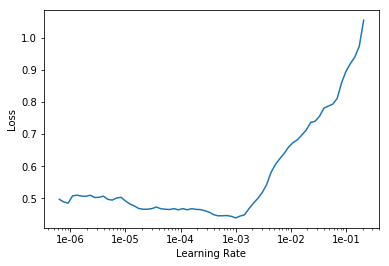

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(8, max_lr=slice(1e-4,lr/2))

Total time: 01:27
epoch  train_loss  valid_loss  error_rate
1      0.477160    0.642148    0.245614    (00:10)
2      0.384825    0.599510    0.210526    (00:10)
3      0.336013    0.786081    0.225146    (00:11)
4      0.292685    0.623644    0.169591    (00:11)
5      0.235725    0.555675    0.166667    (00:10)
6      0.190709    0.512871    0.146199    (00:10)
7      0.143758    0.484810    0.149123    (00:10)
8      0.113511    0.498301    0.146199    (00:10)



In [30]:
learn.save('stage-2_128')

## Interpretation

In [31]:
learn.load('stage-2_128')
print('loaded stage-2_128 model')

loaded stage-2_128 model


In [32]:
interp = ClassificationInterpretation.from_learner(learn)

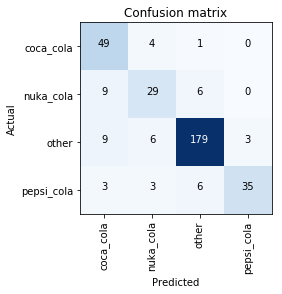

In [33]:
interp.plot_confusion_matrix()

## Increase image size

Retrain the model with larger images

In [39]:
data = (src.datasets()
        .transform(get_transforms(), size=size_big)
        .databunch(bs=bs//2)
        .normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 299, 299])

In [40]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


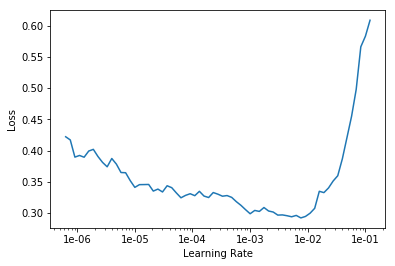

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr=2e-4

In [43]:
learn.fit_one_cycle(3, slice(lr))

Total time: 00:51
epoch  train_loss  valid_loss  error_rate
1      0.263913    0.408205    0.143275    (00:19)
2      0.255308    0.368558    0.125731    (00:16)
3      0.221170    0.363231    0.134503    (00:15)



In [44]:
learn.save('stage-1-299-rn50')

In [45]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


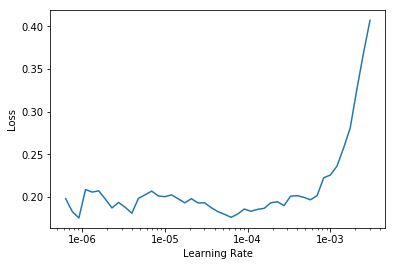

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(6, slice(1e-6, lr/5))

Total time: 01:56
epoch  train_loss  valid_loss  error_rate
1      0.195245    0.389688    0.137427    (00:19)
2      0.180353    0.339056    0.125731    (00:19)
3      0.183691    0.353740    0.128655    (00:19)
4      0.152375    0.324818    0.122807    (00:19)
5      0.128271    0.335517    0.111111    (00:19)
6      0.123341    0.319205    0.102339    (00:19)



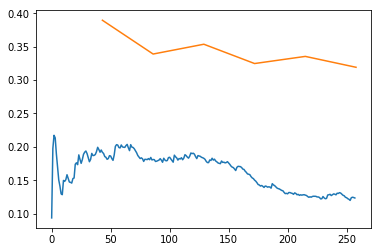

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save('stage-2-299-rn50')

In [50]:
interp = ClassificationInterpretation.from_learner(learn)

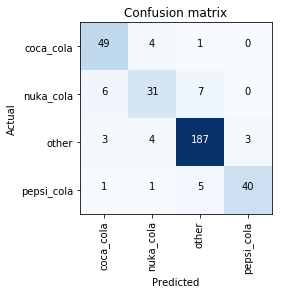

In [51]:
interp.plot_confusion_matrix()

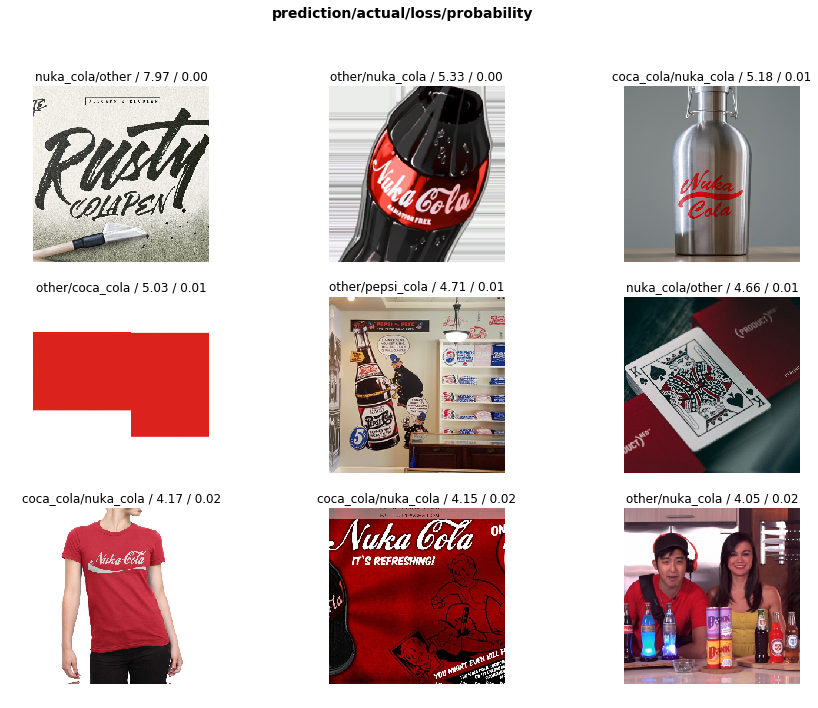

In [52]:
interp.plot_top_losses(9, figsize=(15,11))